## Model Interpretability

We train some complex models to make good predictions for our problem. Now, we want to be able to understand them for having confidence in them, to detect possible bias, to be able to explain the predictions,...

We have train models chosen on two purpose:
- Random Forest for is explainability: it is an in-model so by nature easly interpretable.
- ANN for is modeling capacity: It can catch better non-linear relation but it is a black-box model which is not directly interpretable.

We have chosen for the *IncomeInvestment* prediction to use the random forest model which have the better result and allow us easier interpretability. This choice follow the fact that this set is quite unbalance so we need easy way to interpret it.

For the *AccumulationInvestment* prediction, we decided to choose the ANN because we have seen that playing with hyperparameter (the threshold) we obtained better results (accordingly to our business orientation).

Now we need to interpret them and we will proceed as follows :
- 1. Practice global interpretability: we want to have an overall description of our models.
- 2. Self interpret the predictions: we will have a look on the result, will try to find some pattern with Unsupervised techniques and then try to have an idea about how the prediction can be distributed in our datas.
- 3. Do some local interpretability: on the results of the second step, if we have find some "clusters" while describing the results, we will apply local methods on it 

In [1]:
#Classical Libraries
import numpy as np
import pandas as pd

# Tools'libraries
import eli5
import shap
from sklearn.ensemble import RandomForestClassifier as RF

#Our functions
%cd ..
from src.modelsFct import predictionEnsemble
from src.interpretability import *

2022-06-06 18:18:08.820783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 18:18:08.820823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/emmalito/Bureau/Ensimag/S8_Milan/Fintech/ML_BC2


In [2]:
# first we recup our data, models and target
%store -r X_test
%store -r Inc_test
%store -r Acc_test

#Load the model
%store -r modIncome
%store -r modAccumulation

columns = ["Age", "RatioFeature", "logIncome", "logWealth"]

2022-06-06 18:18:12.322466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emmalito/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-06 18:18:12.322532: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-06 18:18:12.322573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emmalito-KLVL-WXX9): /proc/driver/nvidia/version does not exist
2022-06-06 18:18:12.324279: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# We re-built our dataset
%store -r dataset
data = pd.DataFrame(dataset[["Age"]])
data[["RatioFeature"]] = dataset[["FinancialEducation"]].values/dataset[["RiskPropensity"]].values
data[["logIncome", "logWealth"]] = dataset[["logIncome", "logWealth"]]
data_mean = np.mean(data.values, axis=0)
data_std = np.std(data.values, axis=0)

In [4]:
# We get the prediction of the Test set
predictAcc = (predictionEnsemble(modAccumulation, X_test) > 0.28).astype(int)
predictInc = modIncome.predict(X_test)

### Global Interpretability

In this first part, we would like to have a precise idea of which features have the most impact on predictions, and which kind of impact : positively or negatively. 

To do this, we use Eli5, a python library, to compute weight of features, this allow us a quick global interpretability on the model. Then we use the Shap values to validate this observation and to complete it with the sign of the impact. 


#### ELI5

Eli5 look at model’s parameters and figure out at a global level how the model works. Let us see how behave our models.

In [5]:
# ELI5 for AccumulationInvestment prediction
forest = RF().fit(X_test, predictAcc.ravel()) # We use the first principle of interpretability: Train a simple model on the predict of a complex model
testdf = eli5.explain_weights_df(forest,feature_names=columns) # Explain weights and export them to pandas.DataFrame
testdf.head()

,feature,weight,std
0,logIncome,0.370060,0.041227
1,logWealth,0.366144,0.048645
2,Age,0.138303,0.032574
3,RatioFeature,0.125494,0.020798


We can see that for *AccumulationInvestment*, the most impactful features are **Wealth** and **Income**. They account for approximately 75% of the prediction result. This is huge and can be interpret as a first client behaviour: the more they are at extrem values, the more the prediction is easy. We can already think that their impact are positif in the way to predict a need (true) but we will verify it with shap values.

The remaining 25% is reparted on **Age** and the ratio. The last one seems to have the lower impact and thus not have a particular importance. **Age** can still have an impact but we think that their are too many different type of people, different persona, so age can really differ.

In [6]:
#ELI5 for IncomeInvestment
testdfinc = eli5.explain_weights_df(modIncome,feature_names=columns[0:4])
testdfinc.head()

,feature,weight,std
0,logWealth,0.464512,0.063686
1,Age,0.230849,0.049426
2,logIncome,0.185878,0.027286
3,RatioFeature,0.118762,0.022253


We can see that for *IncomeInvestment*, the most important features are **Wealth** and **Age**. **Wealth** account for nearly 50% of the explanation, meaning the impactof it is really strong on our prediction. It seems logical and we are waiting a positif impact, meaning a big wealth will need to a true prediction, since you are able to invest. 

We were expecting a big impact of **Income**, with the same explanation as above, but the weight is "just" to 18%. Indeed, **Age** seems to play a bigger role, with 23%. As we have say, age is difficult to interpret so we are expecting either positive or negative impact. 

We can still see that the problem is not obvious. However, really high value of wealth seems to be really impactfull and lead the prediction to true. For the rest, we need further explanation. So now let us use Shap values to have a quick visualisation of the data and to see if these impact are observable.

#### Shap Values

With the help of the shap library, we will see the impact, positive or negative, of the features on the predictions. 

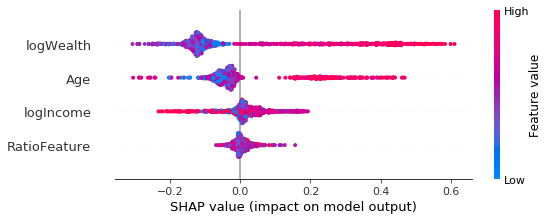

In [7]:
# Shape values for Income Investment
explainerRF = shap.TreeExplainer(modIncome)
shapValuesRF = explainerRF.shap_values(X_test)
shap.summary_plot(shapValuesRF[1], X_test, feature_names=columns)

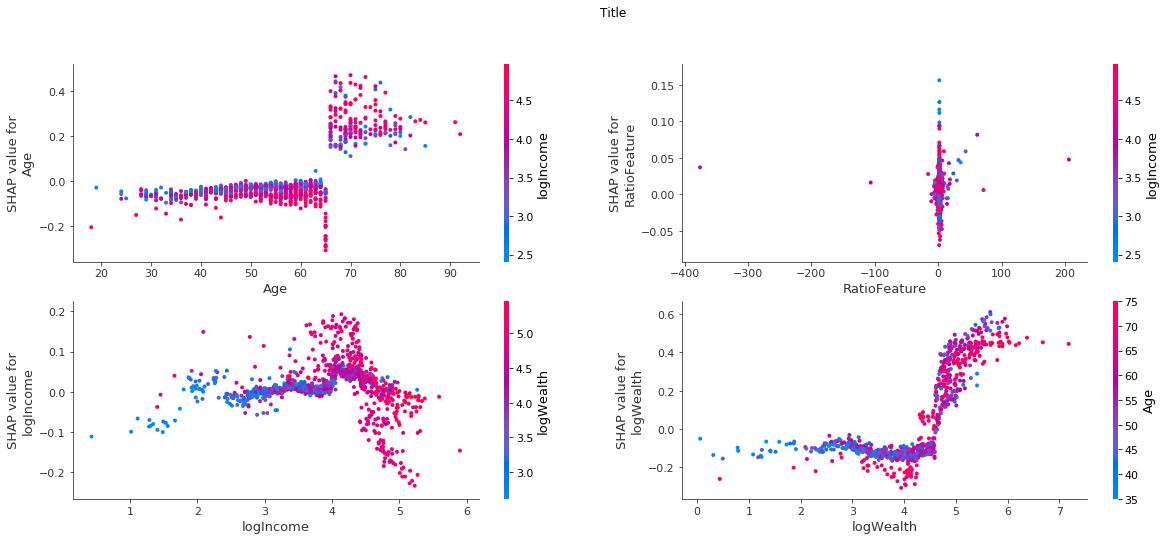

In [8]:
dependenceShap(shapValuesRF[1], X_test*data_std+data_mean, columns)

As we have said, **Wealth** has a important impact on the prediction. And now, we can assure that high value in this feature (feature 3) would push the result toward a True prediction. We can see this on the dependance plot where positive shap value are mostly high value of Wealth.

For the feature **Age**, we can also see that higher value give us the higher shap value. In the dependance plot we can not see patern.

For **RatioFeature** and **Income** features, thanks to the summary plot, the impact is either positive and negative and have a small impact on the prediction.

To conclude, as expected, client with high wealth are more sensible to income investment and we must have to propose them some products. Also, older clients seem more likely to have income need.  

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

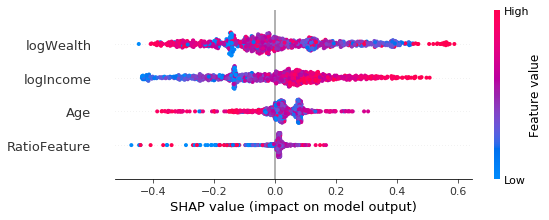

In [9]:
# Shape values for Accumulation Investment
sumShapVal = []
for index in range(3):
    explainerNN = shap.KernelExplainer(modAccumulation[index], X_test[:100,:])
    shapValuesNN = explainerNN.shap_values(X_test)
    sumShapVal.append(shapValuesNN[0])
shap.summary_plot(sum(sumShapVal)/3, X_test, feature_names=columns)

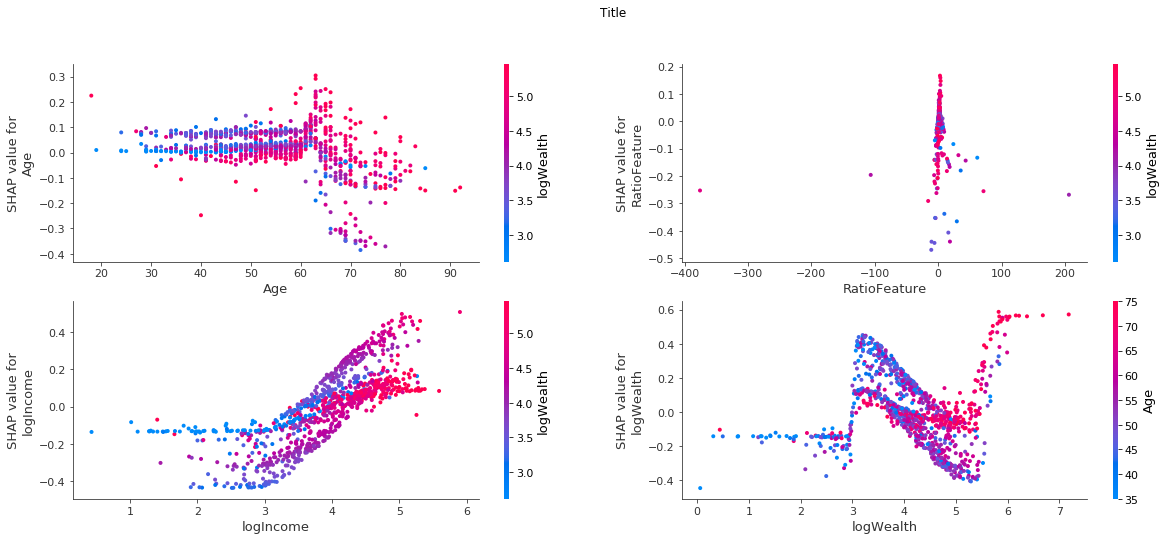

In [10]:
dependenceShap(sum(sumShapVal)/3, X_test*data_std+data_mean, columns)

As expected, **Income** behave as we have seen before for the wealth. Meaning high income leeds you to an accumulation need. This is not really reflected on the dependance plot.

**Wealth**, the most important feature in this case, seems to have a strange shap values repartition. On the dependance plot, high wealth value differ between small or high shap values. Very small wealth are between [-0.2,0] meaning as expected that it will push the client to not have accumulation need.

For the feature **Age**, we can say that older people are also non-need client. 

For **RatioFeature** the impact is negligeable.

To conclude, there is no clear pattern here. We see that **Wealth** and **Age** will play an important role on the prediction and older clients are most likely people without accumulation need. 

### Local Interpretability

Now, we will interest about how our investisors look like. We will compute clusters and will see which structures will appear.

We will train a clustering model to see if we can find one or more. It is a Kmedoids model because it is less sensitive to noise and outlier in data than a Kmean.

We will do it on separating in both target into the subset of true prediction. Thus we have 2 dataset to train. We only choose true prediction because it is the ones that matter, we want to explain why a people have some need.

In [5]:
# Dataframe with the positive prediction
columns = ['Age', 'Ratio', 'logIncome', 'logWealth', 'PredAcc', 'PredInc']
df =  pd.DataFrame(np.c_[(X_test*data_std+data_mean), predictAcc, predictInc], columns=columns)
df_scale =  pd.DataFrame(np.c_[(X_test), predictAcc, predictInc], columns=columns)

# let's recup exactly the peole who have need or not in both target
UL_scale = df_scale.drop(["PredAcc", "PredInc"], axis=1).values
UL = df.values

# We recup positive target
Acc_true  = UL_scale[(UL[:,4]==1)][:,[0,2,3]]
Inc_true  = UL_scale[(UL[:,5]==1)][:,[0,2,3]]

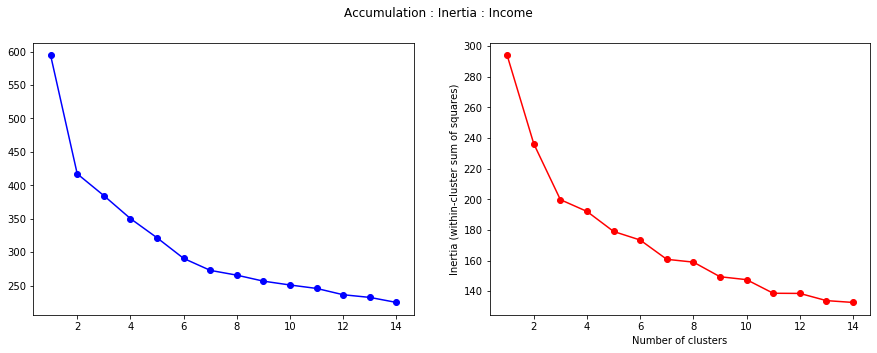

In [6]:
# Plot the inertias
plotInertia(Acc_true, Inc_true)

Here, we plot the inertia for the Kmedoïd model for income and accumulation prediction. For both, the best choice is a high number of cluster (10 approximately), but for better explainability we choose for both 4 cluters. We choose it because it seems that passed 4, the inertia reduce slowly and also because 4 is most likely to have difference in cluster. 

Now, we are going to proceed in the following way : 
- first, we compute the Kmedoids with 4 clusters and look at the results (clusters center and distribution of samples in the clusters)
- then we look at the boxplot to have a additional explanation 
- finaly we conclude on our types of people

Let us start with accumulation needs

In [7]:
# Clusters center for Accumulation prediction
labels = medoids(4, Acc_true, data_std, data_mean)

cluster centers are :

Age: 66.0 Income: 3.991857442737993 Wealth: 4.713498772861468
Age: 43.0 Income: 4.55083988899421 Wealth: 4.241649265162286
Age: 50.0 Income: 3.8919014527766813 Wealth: 3.6976011763285888
Age: 65.0 Income: 4.801933770349916 Wealth: 5.0102333126458705
classes [0 1 2 3] distributed as : [ 91  76 163 115]


Most of the prediction is in the third class. We can see that the cluster center of the second class is younger and has a higher income and wealth. 

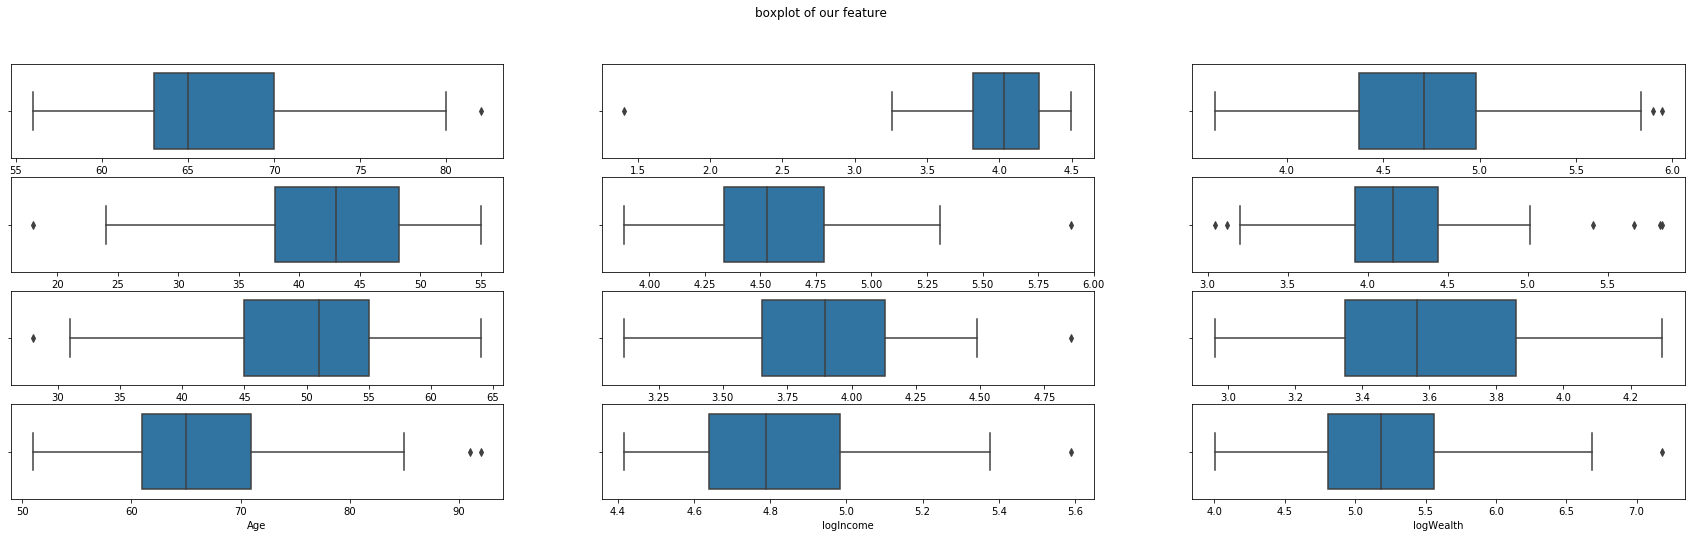

In [16]:
#Cluster distribution for Accumulation prediction
distrib = []
for i in range(4):
    distrib.append(repartition(labels, i, Acc_true, data_std, data_mean))
boxplot_cluster(distrib)

We can see that as expected, these 4 cluster are quite different in some way : 
- 1. between 49-55 years old that have a mid-well wealth and income (between 4-4.5)
- 2. between 38-45 years old that have a mid wealth and income (between 3-4 approximately)
- 3. between 62-71 years old that have a good wealth and income (between 4.5-5.5 approximately)
- 4. between 55-64 years old that have a mid wealth and income (between 3-4 approximately)

So here we have our type of people for the accumulation need. Of course we can have choose more cluster but the goals is to have few groups in order to classify people and to have clear action for them. 

Let's now see for income needs 

In [8]:
# Clusters center for Income prediction
labels_inc = medoids(4, Inc_true, data_std, data_mean)

cluster centers are :

Age: 51.0 Income: 4.3262750225301145 Wealth: 4.96296276803661
Age: 72.0 Income: 4.376049631927487 Wealth: 4.863073777970833
Age: 66.0 Income: 4.948980076064599 Wealth: 5.4039828177083065
Age: 63.0 Income: 3.832388268839755 Wealth: 4.875773969885588
classes [0 1 2 3] distributed as : [63 64 58 69]


Here the clusters distribution is more balanced. The centers are differents: we can distinguish different age and different class social.

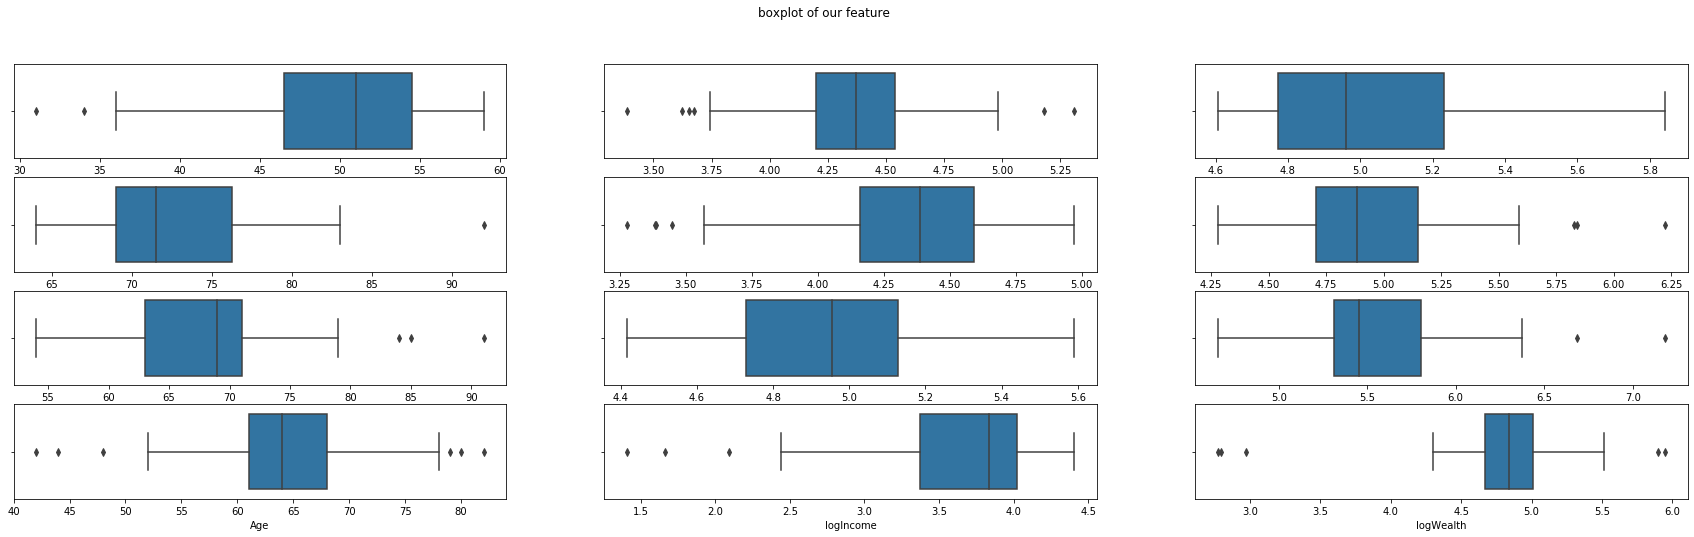

In [18]:
#Cluster distribution for Income prediction
distrib = []
for i in range(4):
    distrib.append(repartition(labels_inc, i, Inc_true, data_std, data_mean))
boxplot_cluster(distrib)

Here, once again, we have interesting centroïds to explain our clusters (see the boxplot in the annex):
- 1. 50% of the observations is between 66 and 72 years old. 75% of them have a logIncome in 3.53 and 4.67. Their logWealth is between 4.61 and 4.99 for 50%.
- 2. 50% of the observations is between 69 and 75 years old. 75% of them have a logIncome in 3.89 and 4.66. Their logWealth is between 4.73 and 5.13 for 50%.
- 3. 50% of the observations is between 46 and 55 years old. 50% of them have a logIncome in 4.12 and 4.48. Their logWealth is between 4.76 and 5.22 for 50%.
- 4. 50% of the observations is between 63 and 70 years old. 75% of them have a logIncome in 3.38 and 4.40. Their logWealth is between 4.65 and 5.02 for 50%.

# Conclusion